## Multivariate Regression

In [22]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state

import statsmodels.api as sm
import statsmodels.formula.api as smf

from nose.tools import assert_equal, assert_is_not, assert_in
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal

sns.set(style="white", font_scale=2.0)

In [23]:
filename = '2001.csv'

usecols = (13, 14, 16, 18)
columns = ['AirTime', 'ArrDelay', 'Origin', 'Distance']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data.loc[all_data['Origin'] == 'ORD'].dropna()

### Use Seaborn to plot a linear regression model

In [27]:
def plot_seaborn_reg(df):
    '''
    Uses Seaborn to create a scatter plot of "AirTime" vs "Distance" columns in "df".
    Also fits a linear regression model in the same plot.
    
    Parameters
    ----------
    df: A pandas.DataFrame. Should have columns named "AirTime" and "Distance".
    
    Returns
    -------
    A matplotlib
    '''
    
    ax = sns.regplot(data=df, x='AirTime', y='Distance')
    ax.set(title='Seaborn linear regression',
       xlabel='Air time (min)', xlim=(-100, 700),
       ylabel='Distance (miles)', ylim=(-2000, 6000))
    return ax

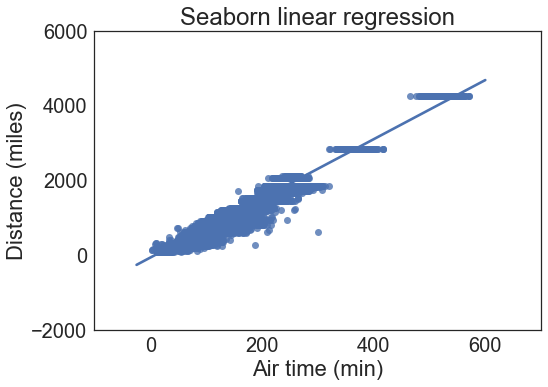

In [28]:
ax1 = plot_seaborn_reg(local)

In [29]:
assert_equal(isinstance(ax1, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(ax1.lines), 1)
assert_equal(len(ax1.collections), 2, msg="Your plot doesn't have a regression line.")

assert_is_not(len(ax1.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax1.xaxis.get_label_text(), "AirTime", msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax1.yaxis.get_label_text(), "Distance", msg="Change the y-axis label to something more descriptive.")
    
x, y = ax1.collections[0].get_offsets().T
assert_array_equal(x, local["AirTime"])
assert_array_equal(y, local["Distance"])

### Split a DataFrame into a testing and a test set

In [34]:
def get_train_test(df, train_columns, test_columns, test_size, random_state):
    '''
    Uses sklearn.train_test_split to split "df" into a testing set and a test set.
    The "train_columns" parameter lists the attributes that will be used for training.
    The "test_columns" lists the column that we are trying to predict.
    The "test_size" should be between 0.0 and 1.0 and represents the proportion of the
    dataset to include in the test split.
    The "random_state" parameter is used in sklearn.train_test.split.
    
    Parameters
    ----------
    train_columns: A list of strings
    test_columns: A list of strings
    test_size: A float
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    A 4-tuple of 
    '''
    
    x_train, x_test, y_train, y_test = train_test_split(df[train_columns], df[test_columns], test_size=test_size,random_state=random_state)
    return x_train, x_test, y_train, y_test   

In [35]:
X_train, X_test, y_train, y_test = get_train_test(
    df=local,
    train_columns=['AirTime', 'ArrDelay'],
    test_columns=['Distance'],
    test_size=0.2,
    random_state=check_random_state(0)
)

In [36]:
assert_equal(len(X_train), np.round(len(local) * 0.8))
assert_frame_equal(
    X_train.iloc[:5, :],
    pd.DataFrame(
        index=[455345,  912717, 2456409, 1431043,  721122],
        data={'AirTime': [ 125., 44., 98., 225., 247.], 'ArrDelay': [56., -24., 31., -9., -2.]}
    )
)

assert_equal(len(X_test), np.round(len(local) * 0.2))
assert_frame_equal(
    X_test.iloc[:5, :],
    pd.DataFrame(
        index=[3639407, 1220091, 2772255, 5715261, 1979336],
        data={'AirTime': [98., 224., 231., 230., 81.], 'ArrDelay': [ 14., -22.,  -8.,   0.,   7.]}
    )
)

assert_equal(len(y_train), np.round(len(local) * 0.8))
assert_frame_equal(
    y_train.iloc[:5, :],
    pd.DataFrame(
        index=[455345, 912717, 2456409, 1431043, 721122],
        data={'Distance': [ 802,  235,  733, 1745, 1721]}
    )
)

assert_equal(len(y_test), np.round(len(local) * 0.2))
assert_frame_equal(
    y_test.iloc[:5, :],
    pd.DataFrame(
        index=[3639407, 1220091, 2772255, 5715261, 1979336],
        data={'Distance': [606, 1781, 1846, 1721, 594]}
    )
)

### Multiple independent variables

In [98]:
def get_statsmodels_reg(df_fit, X_predict):
    '''
    Trains OLS on the columns in "df_fit" and makes a prediction for "X_predict".
    Returns the predicted `DepDelay` values.
    
    Parameters
    ----------
    df_fit: A pandas.DataFrame. Should have "AirTime", "ArrDelay", and "Distance" columns.
    X_predict: A pandas.DataFrame. Should have "AirTime" and "ArrDelay" columns.
    
    Returns
    -------
    A numpy array
    '''
    
    model = sklearn.linear_model.LinearRegression()
    model.fit(df_fit.iloc[:,[0,1]],df_fit.iloc[:,[2]])
    y_pred = model.predict(X_predict)
    return y_pred.flatten()

In [99]:
df_train = pd.DataFrame({
    "AirTime": X_train["AirTime"].values,
    "ArrDelay": X_train["ArrDelay"].values,
    "Distance": y_train["Distance"].values})

X_pred = pd.DataFrame({
    'AirTime': np.linspace(X_test['AirTime'].min(), X_test['AirTime'].max(), 10),
    'ArrDelay': np.linspace(X_test['ArrDelay'].min(), X_test['ArrDelay'].max(), 10)
    })

y_pred = get_statsmodels_reg(df_train, X_pred)

In [100]:
assert_array_almost_equal(
    y_pred,
    np.array([  -10.24755291,   432.77802136,   875.80359563,  1318.8291699 ,
        1761.85474417,  2204.88031843,  2647.9058927 ,  3090.93146697,
        3533.95704124,  3976.9826155 ])
    )


### Plot the multivariate regression model

In [114]:
def plot_statsmodels_reg(df_test, df_pred):
    '''
    Plots the follwoing:
    1. A scatter plot of the "AirTime" column of "df_test" on the x-axis
       and the "Distance" column of "df_test" on the y-axis,
    2. A straight line (multivariate linear regression model) of the
       "AirTime" column of "df_pred" on the x-axis and the "Distance"
       column of "df_pred" on the y-axis.
              
    Parameters
    ----------
    df_test: A pandas.DataFrame
    df_pred: A pandas.DataFrame
    
    Returns
    -------
    A matplotlib.Axes object
    '''
    
    ax = sns.regplot(x=df_test['AirTime'], y=df_test['Distance'],fit_reg=False)
    plt.plot(df_pred['AirTime'], df_pred['Distance'], color='red')
    ax.set(title='statsmodels regression',
       xlabel='Air time (minutes)', xlim=(-100, 600),
       ylabel='Distance (miles)', ylim=(-1000, 5000))
    return ax

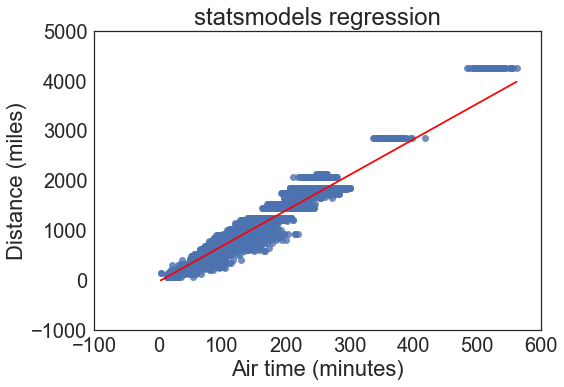

In [115]:
df_test = pd.DataFrame({
    'AirTime': X_test['AirTime'].values,
    'Distance': y_test['Distance'].values
    })

df_pred = pd.DataFrame({
    'AirTime': X_pred['AirTime'].values,
    'Distance': y_pred
    })

ax2 = plot_statsmodels_reg(df_test, df_pred)

In [116]:
assert_equal(isinstance(ax2, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(ax2.lines), 1)
assert_equal(len(ax2.collections), 1, msg="You should turn off Seaborn regression.")

assert_is_not(len(ax2.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax2.xaxis.get_label_text(), "AirTime", msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax2.yaxis.get_label_text(), "Distance", msg="Change the y-axis label to something more descriptive.")
    
x_scatter, y_scatter = ax2.collections[0].get_offsets().T
assert_array_equal(x_scatter, df_test["AirTime"])
assert_array_equal(y_scatter, df_test["Distance"])

line = ax2.get_lines()[0]
x_line = line.get_xdata()
y_line = line.get_ydata()
assert_array_equal(x_line, df_pred["AirTime"])
assert_array_almost_equal(y_line, y_pred)